In [2]:
# install.packages("stringr")
# install.packages("tidyr")
# install.packages("dplyr")
# install.packages("zoo")
# install.packages("Metrics")
# install.packages("caret")
# install.packages("MASS")
# install.packages("ggplot2")
# install.packages("reshape2")
# install.packages("mltools")
# install.packages("DescTools")
# install.packages("plotly")


# library(stringr)
# library(tidyr)
# library(dplyr)
# library(zoo)
# library(Metrics)
# library(caret)
# library(MASS)
# library(ggplot2)
# library(reshape2)
# library(mltools)
# library(DescTools)
# library(plotly)

In [3]:
GPU = read.csv("/kaggle/input/computerparts/All_GPUs.csv",header=TRUE,na.strings=c("","\n- ","\n","\nUnknown Release Date "))
GPU_new = GPU[,c("Memory","Resolution_WxH","Manufacturer","Core_Speed","Memory_Bus","Memory_Speed","Memory_Type","Process","Pixel_Rate","Texture_Rate")]

In [4]:
print( summary(GPU_new) )

    Memory          Resolution_WxH     Manufacturer        Core_Speed       
 Length:3406        Length:3406        Length:3406        Length:3406       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
  Memory_Bus        Memory_Speed       Memory_Type          Process         
 Length:3406        Length:3406        Length:3406        Length:3406       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
  Pixel_Rate        Texture_Rate      
 Length:3406        Length:3406       
 Class :character   Class :character  
 Mode  :character   Mode  :character  


In [5]:
print( apply(is.na(GPU_new),2,sum) )

        Memory Resolution_WxH   Manufacturer     Core_Speed     Memory_Bus 
           420            195              0            936             62 
  Memory_Speed    Memory_Type        Process     Pixel_Rate   Texture_Rate 
           105             56            463            544            544 


# Tiền xử lý số liệu

## Chuyển đổi dữ liệu 

In [6]:
helper <- function(x){ 
    if(is.na(x)) 
        {return (NA)} 
    else 
        #strsplit return về 1 list các list: vd 7 MHz -> list(list(7),list(MHz))
        #strsplit[[1]] để truy cập vào list đầu tiên ->list(7)
        #strsplit[[1]][[1]] truy cập phần tử đầu tiên trong list -> 7
        {return (as.double( strsplit(x," ")[[1]][[1]] )) 
    }
}

In [7]:
# Core Speed
# Chuyển đổi từ character về double
GPU_new$Core_Speed <- sapply(GPU_new$Core_Speed, helper)

# Thay thế các missing value bằng trung vị
GPU_new$Core_Speed[is.na(GPU_new$Core_Speed)] = median(GPU_new$Core_Speed, na.rm=T)

In [8]:
# Resolution WxH
# Mode nó chiếm 39% nên điền luôn
# Thay thế các missing value bằng mode
GPU_new$Resolution_WxH[is.na(GPU_new$Resolution_WxH)] = "4096x2160"

# Gom nhóm: 4096x2160 (39%), 2560x1600 (34%), Other (26%)

GPU_new$Resolution_WxH <- ifelse(GPU_new$Resolution_WxH == "4096x2160", 1, 
                        ifelse(GPU_new$Resolution_WxH == "2560x1600", 2, 3))

GPU_new$Resolution_WxH = factor(GPU_new$Resolution_WxH)

In [9]:
GPU_new$Manufacturer = factor(GPU_new$Manufacturer)

In [10]:
GPU_new$Memory = sapply(GPU_new$Memory, helper)
# Thay thế các missing value bằng trung vị
GPU_new$Memory[is.na(GPU_new$Memory)] = median(GPU_new$Memory, na.rm=T)

In [11]:
# Memory Bus
# Chuyển đổi từ character về double
GPU_new$Memory_Bus = sapply(GPU_new$Memory_Bus, helper)
GPU_new <- GPU_new[complete.cases(GPU_new$Memory_Bus), ]

In [12]:
GPU_new$Memory_Speed = sapply(GPU_new$Memory_Speed, helper)
GPU_new <- GPU_new[complete.cases(GPU_new$Memory_Speed), ]

In [13]:
GPU_new <- GPU_new[complete.cases(GPU_new$Memory_Type), ]

GPU_new$Memory_Type = gsub("[^A-Za-z]+.*","",GPU_new$Memory_Type)

GPU_new$Memory_Type = factor(GPU_new$Memory_Type)

In [14]:
# Process
# Chuyển đổi từ character về double
# [^0-9] không phải là số thì bắt đầu regular expression
GPU_new$Process = as.double( gsub("[^0-9]","",GPU_new$Process) )
# Thay thế các missing value bằng trung vị
GPU_new$Process[is.na(GPU_new$Process)] = median(GPU_new$Process, na.rm=T)

In [15]:
# Pixel Rate
# Chuyển đổi từ character về double
GPU_new$Pixel_Rate = sapply(GPU_new$Pixel_Rate, helper)
# Thay thế các missing value bằng trung vị
GPU_new$Pixel_Rate[is.na(GPU_new$Pixel_Rate)] = median(GPU_new$Pixel_Rate, na.rm=T)

In [16]:
# Texture Rate
# Chuyển đổi từ character về double
GPU_new$Texture_Rate = sapply(GPU_new$Texture_Rate, helper)
# Thay thế các missing value bằng trung vị
GPU_new$Texture_Rate[is.na(GPU_new$Texture_Rate)] = median(GPU_new$Texture_Rate, na.rm=T)

In [17]:
# Loại bỏ các giá trị trùng lặp
str(GPU_new)

'data.frame':	3285 obs. of  10 variables:
 $ Memory        : num  1024 512 512 256 256 ...
 $ Resolution_WxH: Factor w/ 3 levels "1","2","3": 2 2 2 2 2 2 2 2 1 3 ...
 $ Manufacturer  : Factor w/ 4 levels "AMD","ATI","Intel",..: 4 1 1 1 1 1 1 1 1 1 ...
 $ Core_Speed    : num  738 980 980 980 980 980 870 980 980 980 ...
 $ Memory_Bus    : num  256 512 256 128 128 128 256 256 256 64 ...
 $ Memory_Speed  : num  1000 828 800 1150 700 1100 1050 800 1250 366 ...
 $ Memory_Type   : Factor w/ 4 levels "DDR","eDRAM",..: 3 3 3 3 3 3 3 3 3 1 ...
 $ Process       : num  55 80 80 65 65 65 55 80 28 28 ...
 $ Pixel_Rate    : num  12 12 10 3 3 3 14 7 25 26 ...
 $ Texture_Rate  : num  47 12 10 7 6 6 35 7 62 60 ...


In [19]:
GPU_new <- GPU_new %>% dplyr::distinct()
str(GPU_new)

ERROR: Error in GPU_new %>% dplyr::distinct(): could not find function "%>%"


In [21]:
numerical = c("Memory","Core_Speed","Memory_Bus","Memory_Speed","Process","Pixel_Rate","Texture_Rate")
categorical = c("Manufacturer","Memory_Type","Resolution_WxH")

In [22]:
GPU_new_log<-GPU_new
GPU_new_log[,numerical]<-log(GPU_new_log[,numerical])
head(GPU_new_log)

,Memory,Resolution_WxH,Manufacturer,Core_Speed,Memory_Bus,Memory_Speed,Memory_Type,Process,Pixel_Rate,Texture_Rate
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,6.931472,2,Nvidia,6.603944,5.545177,6.907755,GDDR,4.007333,2.484907,3.850148
2,6.238325,2,AMD,6.887553,6.238325,6.719013,GDDR,4.382027,2.484907,2.484907
3,6.238325,2,AMD,6.887553,5.545177,6.684612,GDDR,4.382027,2.302585,2.302585
4,5.545177,2,AMD,6.887553,4.852030,7.047517,GDDR,4.174387,1.098612,1.945910
5,5.545177,2,AMD,6.887553,4.852030,6.551080,GDDR,4.174387,1.098612,1.791759
6,5.545177,2,AMD,6.887553,4.852030,7.003065,GDDR,4.174387,1.098612,1.791759


In [23]:
for(var in numerical) {
    result <- any(GPU_new[[var]] < 0)
    print(paste(var, ":", result))
}

[1] "Memory : FALSE"
[1] "Core_Speed : FALSE"
[1] "Memory_Bus : FALSE"
[1] "Memory_Speed : FALSE"
[1] "Process : FALSE"
[1] "Pixel_Rate : FALSE"
[1] "Texture_Rate : FALSE"


In [24]:
for(var in numerical) {
    result <- any(GPU_new_log[[var]] < 0)
    print(paste(var, ":", result))
}

[1] "Memory : FALSE"
[1] "Core_Speed : FALSE"
[1] "Memory_Bus : FALSE"
[1] "Memory_Speed : FALSE"
[1] "Process : FALSE"
[1] "Pixel_Rate : FALSE"
[1] "Texture_Rate : FALSE"


## Summary

In [25]:
summary(GPU_new)

     Memory      Resolution_WxH Manufacturer    Core_Speed       Memory_Bus    
 Min.   :   16   1:1486         AMD   :1267   Min.   : 100.0   Min.   :  32.0  
 1st Qu.: 1024   2:1126         ATI   :  85   1st Qu.: 850.0   1st Qu.: 128.0  
 Median : 2048   3: 673         Intel : 223   Median : 980.0   Median : 128.0  
 Mean   : 2804                  Nvidia:1710   Mean   : 954.8   Mean   : 207.2  
 3rd Qu.: 4096                                3rd Qu.:1050.0   3rd Qu.: 256.0  
 Max.   :32000                                Max.   :1784.0   Max.   :8192.0  
  Memory_Speed  Memory_Type     Process        Pixel_Rate     Texture_Rate   
 Min.   : 100   DDR  : 861   Min.   : 14.0   Min.   :  1.0   Min.   :  1.00  
 1st Qu.: 800   eDRAM:   3   1st Qu.: 28.0   1st Qu.: 13.0   1st Qu.: 27.00  
 Median :1150   GDDR :2409   Median : 28.0   Median : 26.0   Median : 60.00  
 Mean   :1176   HBM  :  12   Mean   : 31.3   Mean   : 33.9   Mean   : 86.54  
 3rd Qu.:1502                3rd Qu.: 40.0   3rd Q

In [26]:
print( apply(is.na(GPU_new),2,sum) )

        Memory Resolution_WxH   Manufacturer     Core_Speed     Memory_Bus 
             0              0              0              0              0 
  Memory_Speed    Memory_Type        Process     Pixel_Rate   Texture_Rate 
             0              0              0              0              0 


In [27]:
head(GPU_new, 10)

,Memory,Resolution_WxH,Manufacturer,Core_Speed,Memory_Bus,Memory_Speed,Memory_Type,Process,Pixel_Rate,Texture_Rate
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,1024,2,Nvidia,738,256,1000,GDDR,55,12,47
2,512,2,AMD,980,512,828,GDDR,80,12,12
3,512,2,AMD,980,256,800,GDDR,80,10,10
4,256,2,AMD,980,128,1150,GDDR,65,3,7
5,256,2,AMD,980,128,700,GDDR,65,3,6
6,256,2,AMD,980,128,1100,GDDR,65,3,6
7,2048,2,AMD,870,256,1050,GDDR,55,14,35
8,256,2,AMD,980,256,800,GDDR,80,7,7
9,2048,1,AMD,980,256,1250,GDDR,28,25,62


# Thống kê tả

In [28]:
mean<-apply(GPU_new[,numerical],2,mean)
sd<-apply(GPU_new[,numerical],2,sd)
min<-apply(GPU_new[,numerical],2,min)
max<-apply(GPU_new[,numerical],2,max)
median<-apply(GPU_new[,numerical],2,median)
data.frame(mean,sd,min,max,median)

,mean,sd,min,max,median
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Memory,2804.30320,2666.82705,16,32000,2048
Core_Speed,954.80000,238.58058,100,1784,980
Memory_Bus,207.15495,256.60375,32,8192,128
Memory_Speed,1175.86423,445.19639,100,2127,1150
Process,31.30411,14.89158,14,150,28
Pixel_Rate,33.90350,33.94405,1,260,26
Texture_Rate,86.54460,84.79845,1,717,60


In [29]:
mean<-apply(GPU_new_log[,numerical],2,mean)
sd<-apply(GPU_new_log[,numerical],2,sd)
min<-apply(GPU_new_log[,numerical],2,min)
max<-apply(GPU_new_log[,numerical],2,max)
median<-apply(GPU_new_log[,numerical],2,median)
data.frame(mean,sd,min,max,median)

,mean,sd,min,max,median
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Memory,7.522597,1.0159079,2.772589,10.373491,7.624619
Core_Speed,6.822965,0.3011958,4.605170,7.486613,6.887553
Memory_Bus,5.138826,0.5716723,3.465736,9.010913,4.852030
Memory_Speed,6.977811,0.4692010,4.605170,7.662468,7.047517
Process,3.363200,0.3872217,2.639057,5.010635,3.332205
Pixel_Rate,3.042207,1.0896829,0.000000,5.560682,3.258097
Texture_Rate,3.943455,1.1564966,0.000000,6.575076,4.094345


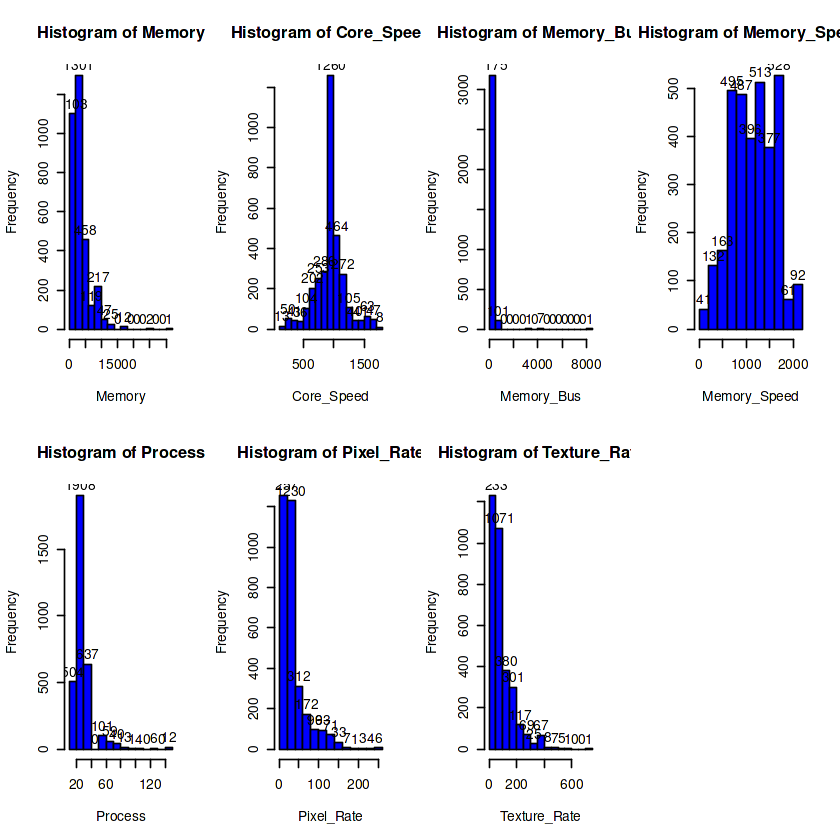

In [30]:
# Chia layout thành 2 hàng và 4 cột
par(mfrow=c(2,4))

# Vẽ histogram cho từng biến numerical trong GPU_new
for (i in 1:length(numerical)) {
  hist_data <- GPU_new[[numerical[i]]]
  hist(hist_data, 
       xlab = names(GPU_new)[which(names(GPU_new) == numerical[i])], 
       main = paste("Histogram of", names(GPU_new)[which(names(GPU_new) == numerical[i])]), 
       labels = TRUE, 
       col = "blue")
}


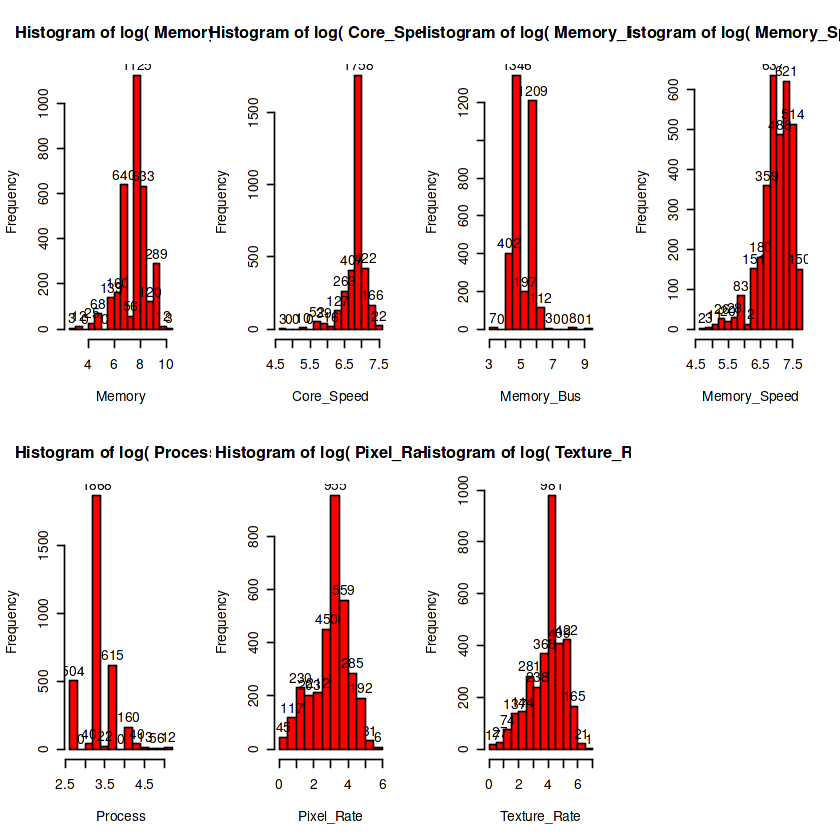

In [31]:

# Chia layout thành 2 hàng và 4 cột
par(mfrow=c(2, 4))

# Vẽ histogram cho từng biến numerical trong GPU_new
for (i in 1:length(numerical)) {
  hist_data <- GPU_new_log[[numerical[i]]]
  hist(hist_data, 
       xlab = names(GPU_new_log)[which(names(GPU_new_log) == numerical[i])], 
       main = paste("Histogram of log(", names(GPU_new_log)[which(names(GPU_new_log) == numerical[i])], ")"), 
       labels = TRUE, 
       col = "red")
}


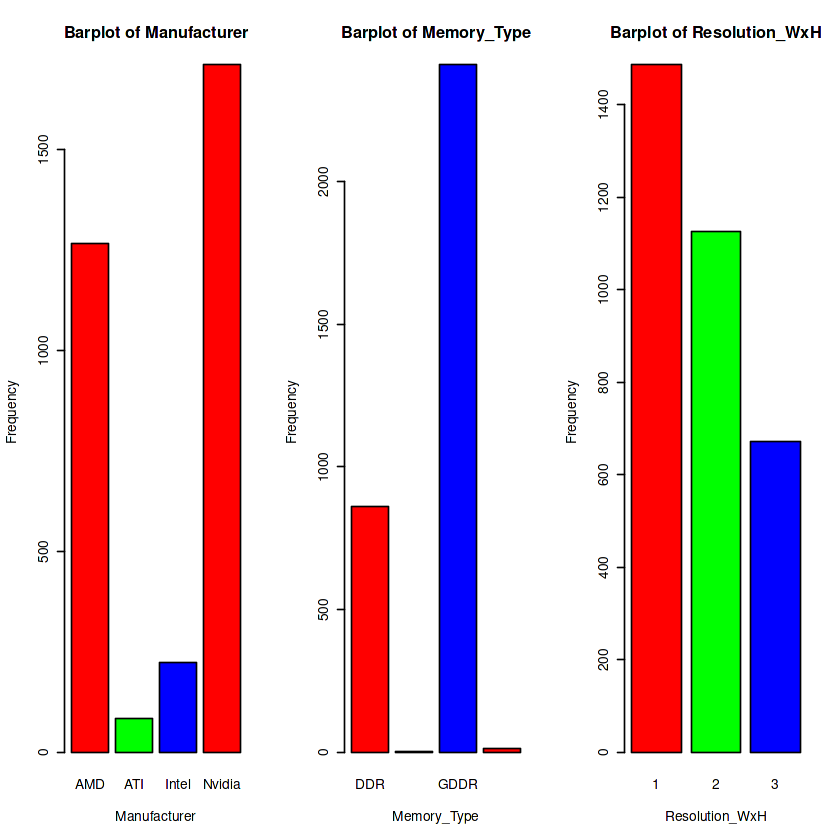

In [51]:
par(mfrow=c(1,3))
barplot(table(GPU_new$Manufacturer), xlab="Manufacturer", ylab="Frequency", main="Barplot of Manufacturer", col=c("red","green","blue"))
barplot(table(GPU_new$Memory_Type), xlab="Memory_Type", ylab="Frequency", main="Barplot of Memory_Type", col=c("red","green","blue"))
barplot(table(GPU_new$Resolution_WxH), xlab="Resolution_WxH", ylab="Frequency", main="Barplot of Resolution_WxH", col=c("red","green","blue"))

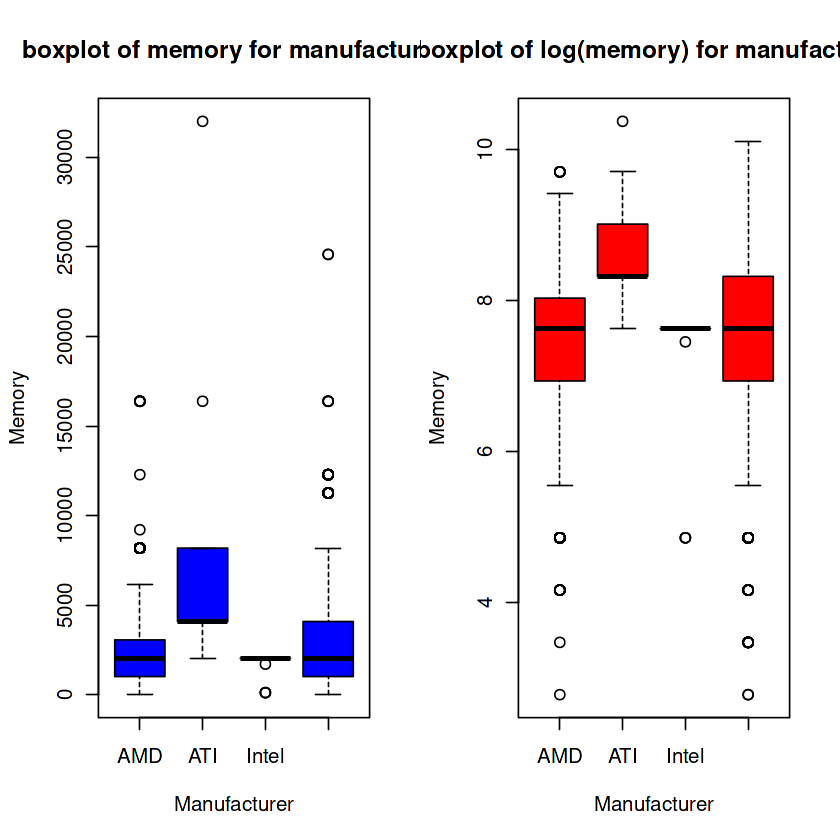

In [32]:
par(mfrow=c(1,2))
boxplot(Memory~Manufacturer, data=GPU_new, main="boxplot of memory for manufacturer", col="blue")
boxplot(Memory~Manufacturer, data=GPU_new_log, main="boxplot of log(memory) for manufacturer", col="red")

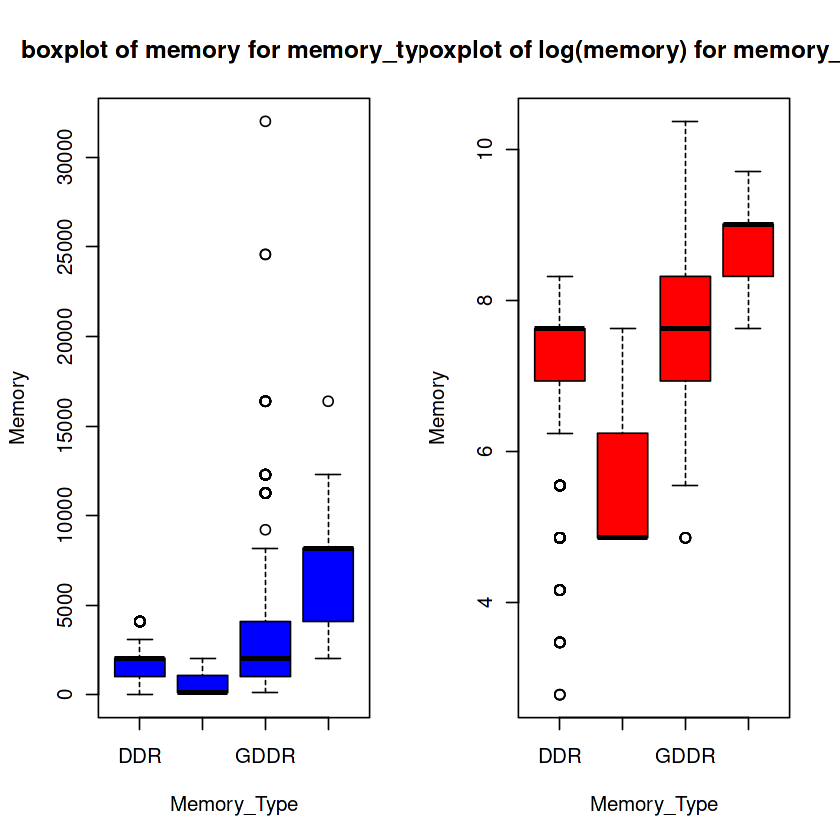

In [33]:
par(mfrow=c(1,2))
boxplot(Memory~Memory_Type, data=GPU_new, main="boxplot of memory for memory_type", col="blue")
boxplot(Memory~Memory_Type, data=GPU_new_log, main="boxplot of log(memory) for memory_type", col="red")

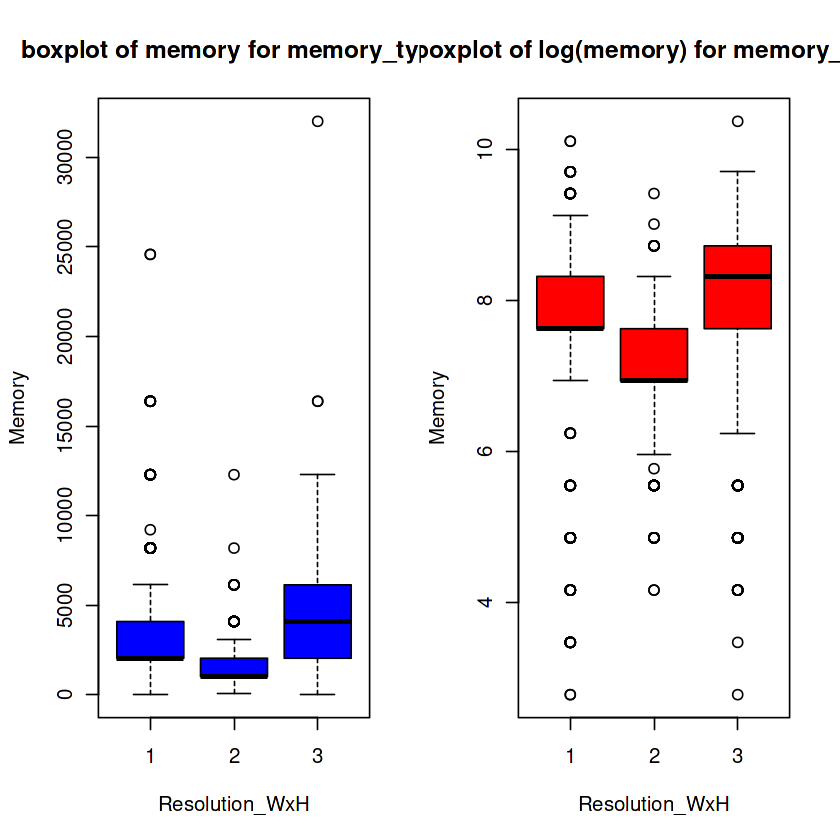

In [34]:
par(mfrow=c(1,2))
boxplot(Memory~Resolution_WxH, data=GPU_new, main="boxplot of memory for memory_type", col="blue")
boxplot(Memory~Resolution_WxH, data=GPU_new_log, main="boxplot of log(memory) for memory_type", col="red")

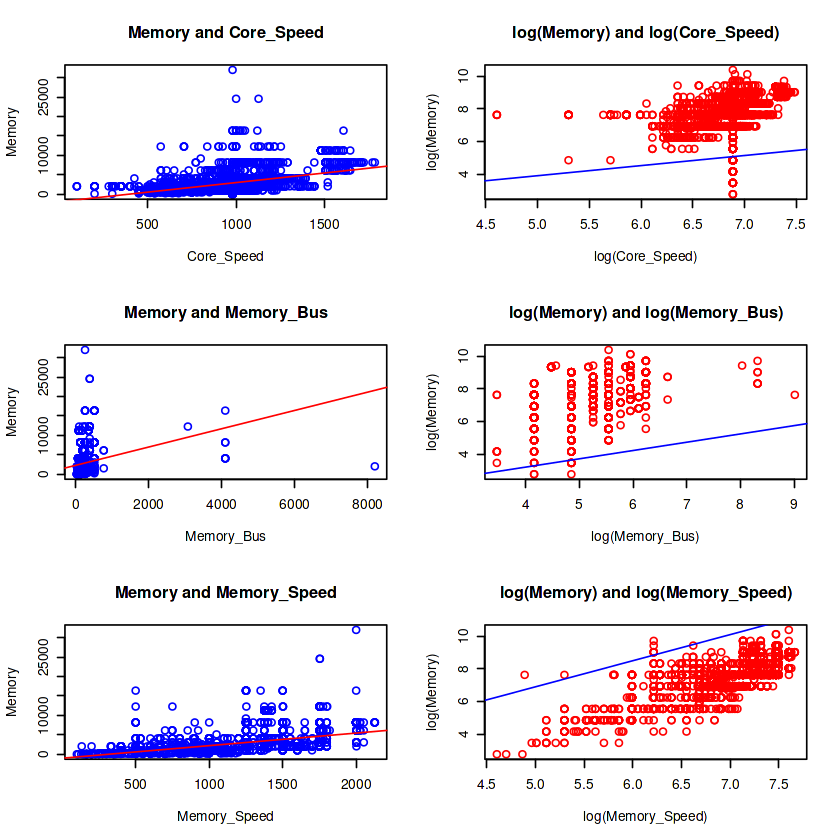

In [41]:
par(mfrow=c(3,2))
plot(GPU_new[, "Core_Speed"], GPU_new[, "Memory"], xlab = "Core_Speed", ylab = "Memory", main = "Memory and Core_Speed", col = "blue")
fit_new <- lm(Memory ~ Core_Speed, data = GPU_new)
abline(fit_new, col = "red")
plot(GPU_new_log[, "Core_Speed"], GPU_new_log[, "Memory"], xlab = "log(Core_Speed)", ylab = "log(Memory)", main = "log(Memory) and log(Core_Speed)", col = "red")
fit_new_log <- lm(log(Memory) ~ log(Core_Speed), data = GPU_new_log)
abline(fit_new_log, col = "blue")

plot(GPU_new[, "Memory_Bus"], GPU_new[, "Memory"], xlab = "Memory_Bus", ylab = "Memory", main = "Memory and Memory_Bus", col = "blue")
fit_new <- lm(Memory ~ Memory_Bus, data = GPU_new)
abline(fit_new, col = "red")
plot(GPU_new_log[, "Memory_Bus"], GPU_new_log[, "Memory"], xlab = "log(Memory_Bus)", ylab = "log(Memory)", main = "log(Memory) and log(Memory_Bus)", col = "red")
fit_new_log <- lm(log(Memory) ~ log(Memory_Bus), data = GPU_new_log)
abline(fit_new_log, col = "blue")

plot(GPU_new[, "Memory_Speed"], GPU_new[, "Memory"], xlab = "Memory_Speed", ylab = "Memory", main = "Memory and Memory_Speed", col = "blue")
fit_new <- lm(Memory ~ Memory_Speed, data = GPU_new)
abline(fit_new, col = "red")
plot(GPU_new_log[, "Memory_Speed"], GPU_new_log[, "Memory"], xlab = "log(Memory_Speed)", ylab = "log(Memory)", main = "log(Memory) and log(Memory_Speed)", col = "red")
fit_new_log <- lm(log(Memory) ~ log(Memory_Speed), data = GPU_new_log)
abline(fit_new_log, col = "blue")

# Thống kê suy diễn

## Hệ số tương quan

In [37]:
# Tạo một dataframe để lưu kết quả
correlation_results <- data.frame(
  Variable = character(),
  Pearson_Correlation = numeric(),
  P_Value = numeric(),
  stringsAsFactors = FALSE
)

# Lặp qua từng biến trong numerical và tính hệ số tương quan Pearson
for (var1 in names(GPU_new[numerical])) {
  test_result <- cor.test(GPU_new[[var1]], GPU_new$Memory)
  
  # Thêm kết quả vào dataframe
  correlation_results <- rbind(correlation_results, 
                                data.frame(Memory = var1,
                                           Pearson_Correlation = test_result$estimate,
                                           P_Value = test_result$p.value))
}

# In ra dataframe kết quả
print(correlation_results)


           Memory Pearson_Correlation       P_Value
cor        Memory           1.0000000  0.000000e+00
cor1   Core_Speed           0.4411560 1.585809e-156
cor2   Memory_Bus           0.2265783  1.640186e-39
cor3 Memory_Speed           0.5394373 1.797899e-247
cor4      Process          -0.3711164 8.590803e-108
cor5   Pixel_Rate           0.7784507  0.000000e+00
cor6 Texture_Rate           0.8086356  0.000000e+00


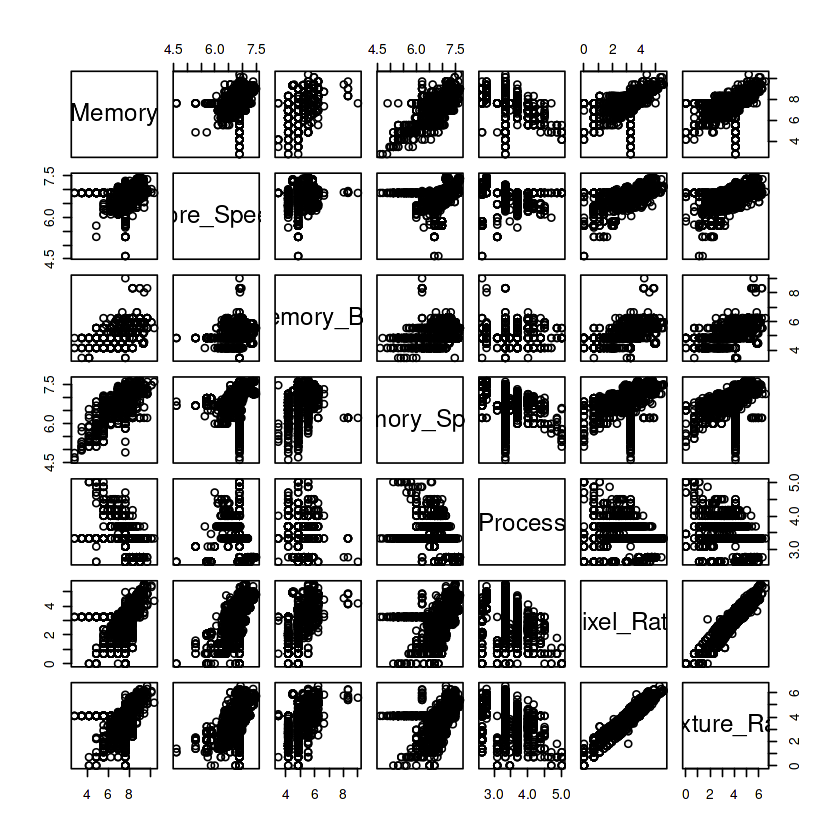

In [38]:
pairs(GPU_new_log[numerical])

In [39]:
# index <- createDataPartition(GPU_new_log$Memory, p = 2/3, list = FALSE)
# train <- GPU_new_log[index,]
# test <- GPU_new_log[index,]
index <- createDataPartition(GPU_new_log$Memory, p = 2/3, list = FALSE)
train <- GPU_new_log[index,]
test <- GPU_new_log[index,]


ERROR: Error in createDataPartition(GPU_new_log$Memory, p = 2/3, list = FALSE): could not find function "createDataPartition"


In [ ]:
model <- lm(Memory ~ ., data = train)

In [ ]:
print( summary(model) )

In [ ]:
predicted_value =  predict(model, newdata= test)

#Thêm 2 cột predicted_value và error vào tập test
test$predicted_value <- predicted_value
test$error <- predicted_value - test$Memory

In [ ]:
# So sánh giá trị tiên đoán (red) và giá trị thực tế (blue)
test %>% 
  gather(Memory, predicted_value, key = "Y", value = "Memory") %>%
  ggplot(aes(x = Memory, fill = Y)) +
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("blue", "red")) +
  theme_bw()


In [ ]:
# Tính toán MAE và MSE
mae_value <- mae(predicted_value, test$Memory)
mse_value <- mse(predicted_value, test$Memory)

# In ra kết quả
cat("MAE (trung bình của sai biệt tuyệt đối): ", mae_value, "\n")
cat("MSE (trung bình bình phương sai số): ", mse_value, "\n")

# Phân tích phương sai

In [ ]:
model_ANOVA <- aov(Memory ~ Manufacturer + Resolution_WxH + Memory_Type, data= GPU_new_log)
summary(model_ANOVA)

In [ ]:
TukeyHSD(model_ANOVA)